# Imports

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
%matplotlib inline

# Camera Calibration

## Build a function to undistort images

In [2]:
def undistort_images( images ):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    # Make a list of calibration images
    cal_images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in cal_images:

        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    
    retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None);
    return list(map(lambda i: cv2.undistort(i, cameraMatrix, distCoeffs, None, cameraMatrix), images))

# Create thresholded binary images

In [3]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1 if orient=='x' else 0, 0 if orient=='x' else 1)
    # 3) Take the absolute value of the derivative or gradient
    sobelabs = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaledSobel = np.uint8(255*sobelabs / (np.max(sobelabs)))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaledSobel)
    binary_output[(scaledSobel >= thresh[0]) & (scaledSobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude 
    sobelMag = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobelScaled = np.uint8( 255*sobelMag / np.max(sobelMag) )
    
    binary_output = np.zeros_like(sobelMag)
    # 5) Create a binary mask where mag thresholds are met
    binary_output[ (sobelScaled >= mag_thresh[0]) & (sobelScaled <= mag_thresh[1]) ]=1
    
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    sobelx_abs = np.absolute(sobelx)
    sobely_abs = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    sobelAngle = np.arctan2(sobely_abs, sobelx_abs)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(sobelAngle)
    binary_output[(sobelAngle >= thresh[0]) & (sobelAngle <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image

    return binary_output

def hls_select(image, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hlsimg = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # 2) Apply a threshold to the S channel
    s_channel = hlsimg[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    # 3) Return a binary image of threshold result
    return binary_output
    
def create_binary_threashold_images(images):
    final_images = []
    for img in images:
        img = np.copy(img)
                
        ksize = 3 
        gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(100, 255))
        grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(100, 255))
        mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(0, 255))
        dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))
        hls_binary = hls_select(img, thresh=(150, 255))

        combined = np.zeros_like(dir_binary)
        combined[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))) & hls_binary == 1] = 1
        
        final_images.append(combined)
    return final_images
        

# Perspective Transform

In [4]:
def transform_to_birds_eye(images):
    final_warped_images = []
    height, width = images[0].shape
    
    src_points = np.array([[
        ((width/2)-50, (height/2)+90), # Top Left
        ((width/2)+50, (height/2)+90), # Top Right
        (200, height),                 # Bottom Left
        (width-200, height),           # Bottom Right

    ]], dtype=np.float32)
    
    dst_points = np.array([[
        ((width/4), 0),        # Top Left
        ((width/4)*3, 0),      # Top Right
        ((width/4), height),   # Bottom Left
        ((width/4)*3, height), # Bottom Right
    ]], dtype=np.float32)

    M = cv2.getPerspectiveTransform(src_points, dst_points)  
     
    for img in images:
        img = np.copy(img)
        warped = cv2.warpPerspective(img, M, (width, height))
        final_warped_images.append(warped)
        
    return final_warped_images

In [5]:
def transform_single(img):
    height, width, _= img.shape
    src_points = np.array([[
        ((width/2)-50, (height/2)+90), # Top Left
        ((width/2)+50, (height/2)+90), # Top Right
        (200, height),                 # Bottom Left
        (width-200, height),           # Bottom Right

    ]], dtype=np.float32)
    
    dst_points = np.array([[
        ((width/4), 0),        # Top Left
        ((width/4)*3, 0),      # Top Right
        ((width/4), height),   # Bottom Left
        ((width/4)*3, height), # Bottom Right
    ]], dtype=np.float32)

    M = cv2.getPerspectiveTransform(src_points, dst_points)        
    warped = cv2.warpPerspective(img, M, (width, height))
    

    f = plt.figure(figsize=(20,10))
    f.add_subplot(1, 2, 1)
    plt.imshow(img)
    for p in src_points[0]:      
        plt.scatter(p[0], p[1])
    
    f.add_subplot(1, 2, 2)
    plt.imshow(warped)
    plt.show(block=True)
    
    
transform_single(undistorted_images[4])

NameError: name 'undistorted_images' is not defined

## Get initial line from first frame 

In [6]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        
        pixels_in_hor_slice = (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
        
        good_left_inds = (pixels_in_hor_slice & \
                         (nonzerox >= win_xleft_low) & \
                         (nonzerox < win_xleft_high)).nonzero()[0]
                         
        good_right_inds = (pixels_in_hor_slice & \
                         (nonzerox >= win_xright_low) & \
                         (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


def fit_polynomial(binary_warped, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fitx, right_fitx, ploty

## Get lane lines given a previous lane line

In [7]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, previous_left_fit, previous_right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###

    def fit_in_left_line(point):
        x, y = point
        line_position = previous_left_fit[0] * y**2 + previous_left_fit[1] * y + previous_left_fit[2]
        return ((line_position - margin) < x and x < (line_position + margin))

    def fit_in_right_line(point):
        x, y = point
        line_position = previous_right_fit[0] * y**2 + previous_right_fit[1] * y + previous_right_fit[2]
        return ((line_position - margin) < x and x < (line_position + margin))

    left_lane_inds = (np.array(list(map(fit_in_left_line, zip(nonzerox, nonzeroy))))).nonzero()[0]
    right_lane_inds = (np.array(list(map(fit_in_right_line, zip(nonzerox, nonzeroy))))).nonzero()[0]

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return left_fitx, right_fitx, ploty, result


# Pipeline

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

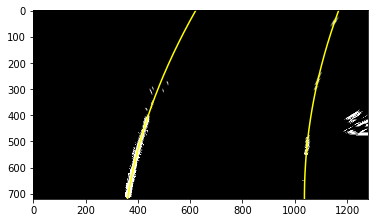

In [8]:
images = list(map(cv2.imread, glob.glob('test_images/*.jpg')))

undistorted_images = undistort_images( images )

threashold_images = create_binary_threashold_images( undistorted_images )

birds_eye_images = transform_to_birds_eye( threashold_images )

img = birds_eye_images[1]

leftx, lefty, rightx, righty = find_lane_pixels(img)

left_fitx, right_fitx, ploty = fit_polynomial(img, leftx, lefty, rightx, righty)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(img, cmap='gray')

# plt.imshow(birds_eye_images[4], cmap='gray')

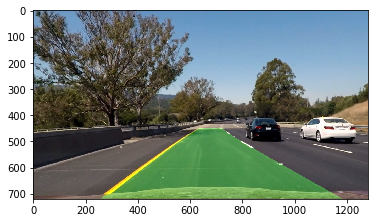

In [23]:
warped = birds_eye_images[1]

height, width = warped.shape
src_points = np.array([[
    ((width/2)-50, (height/2)+90), # Top Left
    ((width/2)+50, (height/2)+90), # Top Right
    (200, height),                 # Bottom Left
    (width-200, height),           # Bottom Right

]], dtype=np.float32)

dst_points = np.array([[
    ((width/4), 0),        # Top Left
    ((width/4)*3, 0),      # Top Right
    ((width/4), height),   # Bottom Left
    ((width/4)*3, height), # Bottom Right
]], dtype=np.float32)

Minv = cv2.getPerspectiveTransform(dst_points, src_points)

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_images[1].shape[1], undistorted_images[1].shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted_images[1], 1, newwarp, 0.3, 0)
cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))